<a href="https://colab.research.google.com/github/Melo95/ML_course_Pavia_23/blob/v2/neural-networks/11.VanillaGAN_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating FashionMNIST data using Vanilla GAN with PyTorch

Adapted from [this](https://debuggercafe.com/vanilla-gan-pytorch/) blog.

In this tutorial, we will generate the digit images from the FashionMNIST dataset using vanilla GAN. We will use the PyTorch deep learning framework to build and train the Generative Adversarial Network.

## Recap of vanilla GANs

GANs contail two neural networks in their architecture. One is the **generator** and the other one is the **discriminator**.

While training a GAN, the generator tries to generate new fake data from a given noisy sample space. And with each iteration, it tries to generate more and more realistic data.

At the same time, the discriminator tries to differentiate the real data from the generated fake data of the generator. While training the discriminator, we provide it with both, the **real data (positive examples)** and the **generated data (negative examples)**. A time will come when the discriminator won’t be able to tell whether the data is real or fake (generated by the generator). This is the time we stop the training and can successfully use the generator to generate realistic data that resembles the input data.

<div>
<img src="https://raw.githubusercontent.com/jngadiub/ML_course_Pavia_23/main/neural-networks/gan-arch.png" width="800"/>
</div>

In vanilla GAN from the [original paper by Goodfellow et al. (2014)](https://arxiv.org/abs/1406.2661) the loss function is the standard binary cross entropy.

$$
\mathcal{L}(\theta^{(G)},\theta^{(D)}) = \mathbb{E}_{x}\log D(x) + \mathbb{E}_{z}(1-D(G(z)))
$$

* $\mathbb{E}_x$ is the expected value over all the data instances. You may recognize this as taking a sample from all the real images.
* $\mathbb{E}_z$ is the expected value over the latent vector or the random noise vector that we give as input to the generator.
* $D(x)$ corresponds to the probability by the discriminator that the given data $x$ is real.
* $G(z)$ is the data generated by the generator when we give it $z$ as the input.
* $D(G(z))$ is the probability by the discriminator that the data generated by the generator $G(z)$ is real.

In GAN training, optimizing the above loss function is a two-sum game for the generator and the discriminator. It is called also **minimax** because the discriminator tries to maximize the $\log D(x)$ term. While at the same time, the generator tries to minimize the $\log(1-D(G(z)))$ term.

## Build and train the GAN

### Modules import

The first step is to import all the modules and libraries that we will need, of course.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

Among all the known modules, we are also importing the `make_grid` and `save_image` functions from `torchvision.utils`. These two functions will help us save PyTorch tensor images in a very effective and easy manner without much hassle.

In [2]:
# we need input and output folders to locally save the dataset and to save the output model
!mkdir input
!mkdir outputs

### Hyperpars definition

Let's define the learning parameters for our generative adversarial network. You should now be familiar with most except for:

* `nz`: This is the latent vector or the noise vector size. The input feature size for the generator is going to be the same as this latent vector size.
* `sample_size` the number of fake images to be generated by the generator from the fixed-size noise vector.
* `k`: the number of gradient descent steps for the discriminator before one step for the generator is taken



In [28]:
#learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size #images to be generated by the generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator #gradient descent
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Download and inspect dataset

We will define the dataset transforms first. The following block of code defines the image transforms that we need for the MNIST dataset.

In [29]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)), #you can decide to transform the data as you wish
])

to_pil_image = transforms.ToPILImage() #transform back to what python can read instead

* first we define transform which will convert the image to tensors and normalizes them as well
* second, the `to_pil_image` will convert the images from PyTorch tensors to the `PIL` (Python Image Library) image format for standard python libraries to be digested.

The next block of code defines the training dataset and training data loader. We will download the FashionMNIST dataset using the dataset module from `torchvision`.

In [30]:
train_data = datasets.FashionMNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Let's look at where data were saved:

In [31]:
!ls input/data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


Now let's plot a few images from the dataset:

In [32]:
def show_images(images, labels, classes, nimages=4):
    fig, axs = plt.subplots(1, nimages, figsize=(10, 5))
    for i in range(nimages):  
        image = images[i]
        axs[i].imshow(image.numpy().squeeze(), cmap='gray')
        axs[i].set_title(classes[labels[i]])
        axs[i].axis('off')
    plt.show()

In [33]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([512, 1, 28, 28])

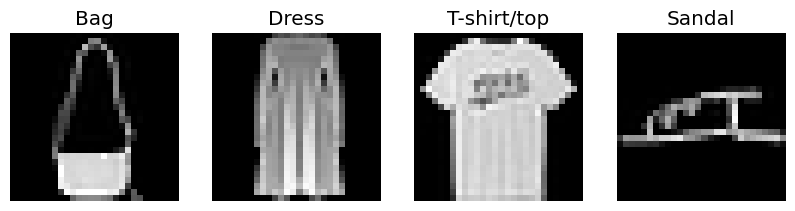

In [34]:
classes = train_data.classes
show_images(example_data, example_targets, classes)

This is all that we need regarding the dataset. In the following two sections, we will define the generator and the discriminator network of Vanilla GAN.

### The Generator Neural Network

Let’s start with building the generator neural network.

It is going to be a very simple network with `Linear` layers, and `LeakyReLU` activations in-between.

In [35]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

We have the `__init__()` function which accepts the `nz` parameter which is going to be the number of input features for the first linear layer of the generator network.

We are using the `Sequential` container to build the neural network.
The first linear layer has `in_features` equal to `nz`, that is equal to `128`. The `out_features` is equal to `256`. Then we have a `LeakyReLU `activation with negative slope of `0.2`.
We have a total of four `Linear` layers and three `LearkyReLU` activations. The last layer’s activation is `Tanh`.

Then we have the `forward()` function which does a forward pass of the batch of images through the neural network. It returns the outputs after reshaping them into `batch_size x 1 x 28 x 28`.

### The Discriminator Neural Network

Here we will define the discriminator neural network.

Remember that the discriminator is a binary classifier. Therefore, we will have to take that into consideration while building the discriminator neural network.

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

* we define `self.n_input = 784` which is the flattened size of the MNIST images (28×28). This is going to be the `in_feature` for the first layer.
* we define the discriminator network using the `Sequential` container. Here, we use `Linear` layers and `LeakyReLU` activations as well. Along with that, we use `Dropout` with rate of 0.3 after the first three `Linear` layers.
* we are using the `Sigmoid` activation after the last `Linear` layer.
* the `forward()` function makes a forward pass of the data through the discriminator network. It returns the binary classification of whether an image is fake or real (0 or 1).

### Define the full model

In [37]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')

print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss()

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

*Note that we are passing the nz (the noise vector size) as an argument while initializing the generator network.*

### Some utility functions

While training the generator and the discriminator, we need to store the epoch-wise loss values for both the networks. We will define two lists for this task. We will also need to store the images that are generated by the generator after each epoch. For that also, we will use a list.

In [38]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

For training the GAN in this tutorial, we need the real image data and the fake image data from the generator. To calculate the loss, we also need real labels and the fake labels. Those will have to be tensors whose size should be equal to the batch size.

Let’s define two functions, which will create tensors of 1s (ones) and 0s (zeros) for us whose size will be equal to the batch size.

In [39]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

For generating fake images, we need to provide the generator with a noise vector. The size of the noise vector should be equal to `nz` (128) that we have defined earlier. To create this noise vector, we can define a function called `create_noise()`.

In [40]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

There is one final utility function. We need to save the images generated by the generator after each epoch. Now, they are torch tensors. To save those easily, we can define a function which takes those batch of images and saves them in a grid-like structure.

In [41]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

### Train functions

First, we will write the function to train the discriminator, then we will move into the generator part.

Let’s write the code first, then we will move onto the explanation part.

In [42]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)


    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

* we get the batch size of the data. Then we use the batch size to create the fake and real labels.
* before doing any training, we first set the gradients to zero
* we get the `output_real` by doing a forward pass of the real data (`data_real`) through the discriminator. We calculates the loss for the real outputs and the real labels.
* we get fake outputs using fake data and calculate the loss for the fake outputs and the fake labels.
* we backpropagate the gradients for the fake and the real loss and update the parameters as well
* we return the total loss for the discriminator network.

Now, we will write the code to train the generator. This is going to a bit simpler than the discriminator coding.

In [43]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss   

* we get the batch size and then create the real labels. Remember that the fake data is actually real for the generator. Therefore, we are using real labels (ones) for training the generator network.
* we set the gradients to zero.
* we pass the fake data through the discriminator and get the outputs then we calculate the loss using the outputs and the real labels -- remember that the generator only generates fake data and it improves after each iteration by taking in the feedback from the discriminator.
* we backpropagate the gradients.
* we update the generator parameters and not the discriminator parameters. Because in this step, we want the generator to learn, not the discriminator. The optimizer parameter in the function definition is the `optim_g` that we will pass as the argument while calling the function.

### Train full GAN model

In this section, we will write the code to train the GAN for some epochs.

First, let’s create the noise vector that we will need to generate the fake data using the generator network.

In [44]:
# create the noise vector
noise = create_noise(sample_size, nz)

It is also a good idea to switch both the networks to training mode before moving ahead.

In [45]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

We will use a simple `for` loop for training our generator and discriminator networks for some epochs.

In [46]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

118it [00:17,  6.74it/s]                         


Epoch 0 of 200
Generator loss: 1.99568594, Discriminator loss: 0.89292806


118it [00:16,  7.26it/s]                         


Epoch 1 of 200
Generator loss: 1.77929604, Discriminator loss: 0.77108026


118it [00:16,  7.30it/s]                         


Epoch 2 of 200
Generator loss: 2.52321625, Discriminator loss: 0.45106381


118it [00:17,  6.92it/s]                         


Epoch 3 of 200
Generator loss: 4.88986254, Discriminator loss: 0.74344510


118it [00:16,  7.31it/s]                         


Epoch 4 of 200
Generator loss: 3.53244281, Discriminator loss: 0.38871661


118it [00:16,  7.17it/s]                         


Epoch 5 of 200
Generator loss: 3.80881190, Discriminator loss: 0.44487387


118it [00:17,  6.90it/s]                         


Epoch 6 of 200
Generator loss: 3.79905725, Discriminator loss: 0.52783781


118it [00:16,  7.19it/s]                         


Epoch 7 of 200
Generator loss: 3.94695020, Discriminator loss: 0.48210099


118it [00:16,  7.17it/s]                         


Epoch 8 of 200
Generator loss: 3.60839391, Discriminator loss: 0.49144220


118it [00:17,  6.88it/s]                         


Epoch 9 of 200
Generator loss: 3.78931761, Discriminator loss: 0.52723610


118it [00:16,  7.21it/s]                         


Epoch 10 of 200
Generator loss: 3.55504107, Discriminator loss: 0.65095055


118it [00:16,  7.11it/s]                         


Epoch 11 of 200
Generator loss: 4.02043915, Discriminator loss: 0.42373011


118it [00:16,  7.09it/s]                         


Epoch 12 of 200
Generator loss: 3.52727175, Discriminator loss: 0.46733430


118it [00:16,  7.29it/s]                         


Epoch 13 of 200
Generator loss: 3.57357168, Discriminator loss: 0.42377737


118it [00:18,  6.32it/s]                         


Epoch 14 of 200
Generator loss: 4.32863808, Discriminator loss: 0.37043771


  3%|▎         | 3/117 [00:00<00:18,  6.28it/s]


KeyboardInterrupt: ignored

* we define `loss_g` and `loss_d` to keep track of the batch-wise loss values for the discriminator and the generator.
* we iterate through the batches. We only need the image data. Therefore, we get the images and load them to the computation device. And we calculate the batch size.
* we run the discriminator for $k$ number of steps. And remember that for our purpose we have defined $k = 1$. This is the least expensive option as this will train one step of the discriminator and one step of the generator. You can play around with the value of $k$. But remember that the computation time will also increase with an increase in the value of $k$. Note that we are passing the discriminator optimizer while calling `train_discriminator()`.
* we again create a new noise vector. This we pass as an argument along with the generator optimizer while calling `train_generator()`.
* we create the final fake images for the current epoch and load them onto the CPU so that we can save them to the disk. We make a grid of those images.
* we save the generated images to disk and append those images to the images list.
* Finally, we calculate the epoch-wise loss of the generator and the discriminator and print those loss values.

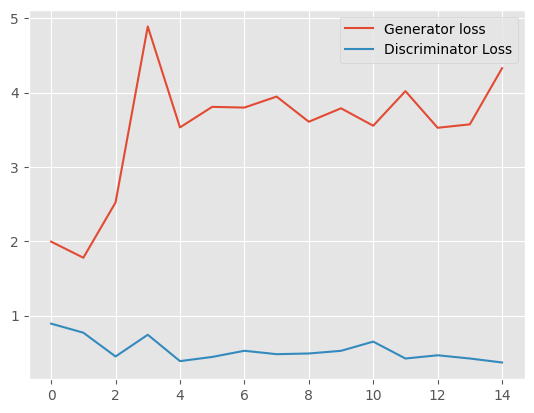

In [47]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

losses_g_cpu = [l.cpu().detach().numpy() for l in losses_g]
losses_d_cpu = [l.cpu().detach().numpy() for l in losses_d]
plt.figure()
plt.plot(losses_g_cpu, label='Generator loss')
plt.plot(losses_d_cpu, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

We can see that for the first few epochs the loss values of the generator are increasing and the discriminator losses are decreasing. This is because **during the initial phases the generator does not create any good fake images. The discriminator easily classifies between the real images and the fake images**. As the training progresses, the generator slowly starts to generate more believable images. At this time, the discriminator also starts to classify some of the fake images as real. Therefore, the generator loss begins to decrease and the discriminator loss begins to increase.

Also, we can clearly see that training for more epochs will surely help.

Now, let’s look at the generated images.

In [ ]:
!ls outputs

In [ ]:
from IPython.display import Image
from IPython.display import display
image_paths = ['outputs/gen_img9.png','outputs/gen_img8.png','outputs/gen_img7.png']
display(Image(filename=image_paths[0]), Image(filename=image_paths[1]), Image(filename=image_paths[2]))

Now let's look at the animation!

In [ ]:
from IPython.display import Image
from IPython.display import display

# Replace 'path/to/your-gif.gif' with the path to your local GIF file
gif_path = 'outputs/generator_images.gif'

# Display the GIF
with open(gif_path, 'rb') as f:
    display(Image(data=f.read(), format='gif'))


## Optional excercise

Modify the code to use the JS and Wasserstein distances and compare.
